# **Data Visualization**

## Objectives

* **Business Requirement 1** - The client is interested in having a study to visually differentiate between healthy and diseased leaves.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/val
* inputs/cherry_leaves_dataset/cherry-leaves/teststst

## Outputs

* pkl file of image shapes
* Mean of images plot
* Variance of images plot
* Differentiate diseased and healthy images
* image montage for dashboard

---

# Set Directory

## Imports

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

In [5]:
cwd= os.getcwd()
os.chdir('/workspaces/cherry-leaves-project')
print("You set a new current directory")
work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspaces/cherry-leaves-project'

### Input Directory

In [6]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = data_dir + '/train'
val_path = data_dir + '/val'
test_path = data_dir + '/test'
print(train_path)
print(val_path)
print(test_path)

inputs/cherry_leaves_dataset/cherry-leaves/train
inputs/cherry_leaves_dataset/cherry-leaves/val
inputs/cherry_leaves_dataset/cherry-leaves/test


### Output Directory

In [7]:
ver = 'v1'
file_path = f'outputs/{ver}'

if 'outputs' in os.listdir(work_dir) and ver in os.listdir(work_dir + '/outputs'):
  print('Old version is available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is available create a new version.


### Labels

In [8]:
labels = os.listdir(train_path)
print('Title for the images are',labels)

Title for the images are ['healthy', 'powdery_mildew']


---

# Image Data Visualization

## Shape

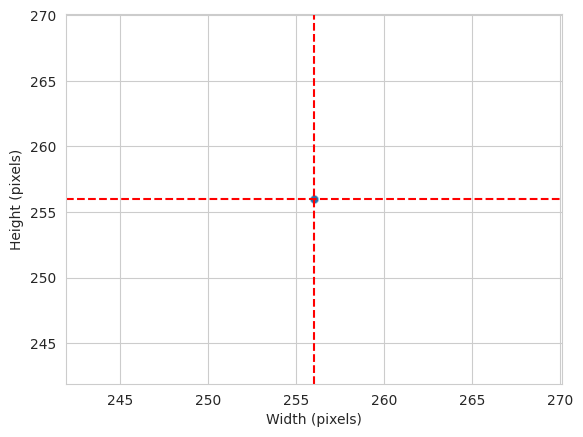

Width average: 256 
Height average: 256


<Figure size 640x480 with 0 Axes>

In [21]:
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1) # image height
    dim2.append(d2) # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
plt.savefig('/outputs/v1/dimensions.png')
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

In [10]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

In [11]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

## Mean and variable of images for each label

In [12]:
from tensorflow.keras.preprocessing import image

def img_as_arr(data_dir, new_size=(50,50), no_img_per_label = 20):
  
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(data_dir + '/' + label):
      # limit to save time
      if counter < no_img_per_label:
        
        img = image.load_img(data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

In [13]:
X, y = img_as_arr(data_dir=train_path,
                           new_size=image_shape,
                          no_img_per_label = 30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


In [14]:
def plot_per_label(X, y, figsize=(12,5), save_image=False):
    for display in np.unique(y):
        sns.set_style("white")
        y = y.reshape(-1,1,1)
        boolean_mask = np.any(y==display,axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis = 0)
        std_img = np.std(arr, axis = 0)
        print(f"==== Label {display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for label {display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
          plt.savefig(f"{file_path}/avg_var_{display}.png", bbox_inches='tight', dpi=150)
        else:
          plt.tight_layout()
          plt.show()
          print("\n")


==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


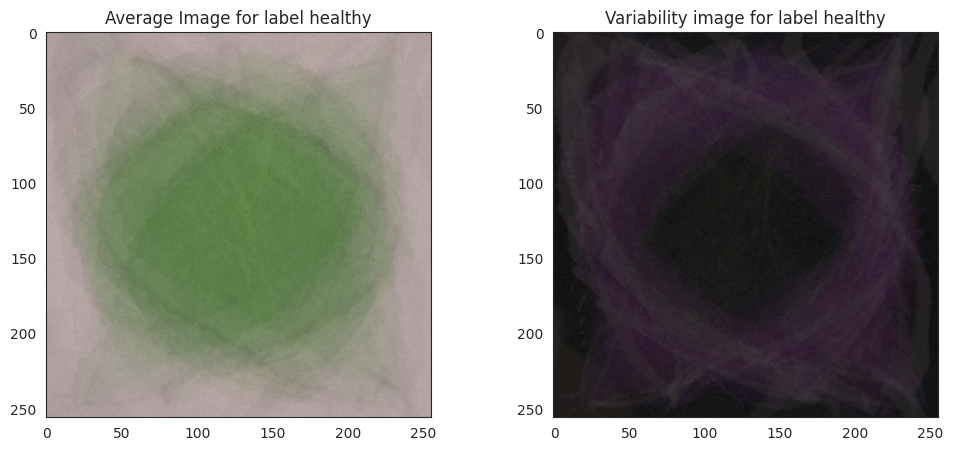

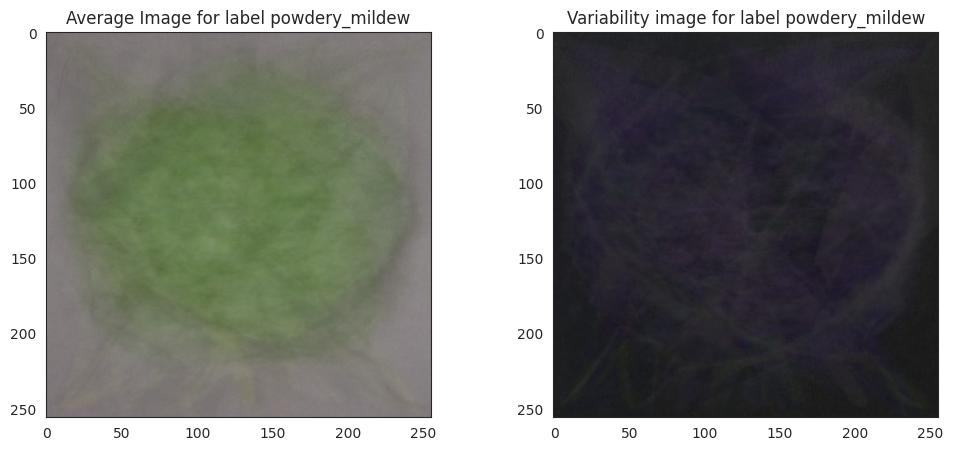

In [15]:
plot_per_label(X=X, y=y, figsize=(12,5),save_image=True)

## Difference between average healthy and average mildew images

In [16]:
def subset_image_label(X,y,label_to_display):
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  df = X[boolean_mask]
  return df

def diff_as_array(X, y, label1, label2, figsize=(20,5), save_image=False):
  sns.set_style("white")

  if (label1 not in np.unique(y)) or (label2 not in np.unique(y)):
    print(f"Either label {label1} or label {label2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1
  images_label = subset_image_label(X, y, label1)
  label1_avg = np.mean(images_label, axis = 0)

  # calculate mean from label2
  images_label = subset_image_label(X, y, label2)
  label2_avg = np.mean(images_label, axis = 0)

  # calculate difference and plot difference, avg label1 and avg label2
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='gray')
  axes[0].set_title(f'Average {label1}')
  axes[1].imshow(label2_avg, cmap='gray')
  axes[1].set_title(f'Average {label2}')
  axes[2].imshow(difference_mean, cmap='gray')
  axes[2].set_title(f'Difference image: Avg {label1} & {label2}')
  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


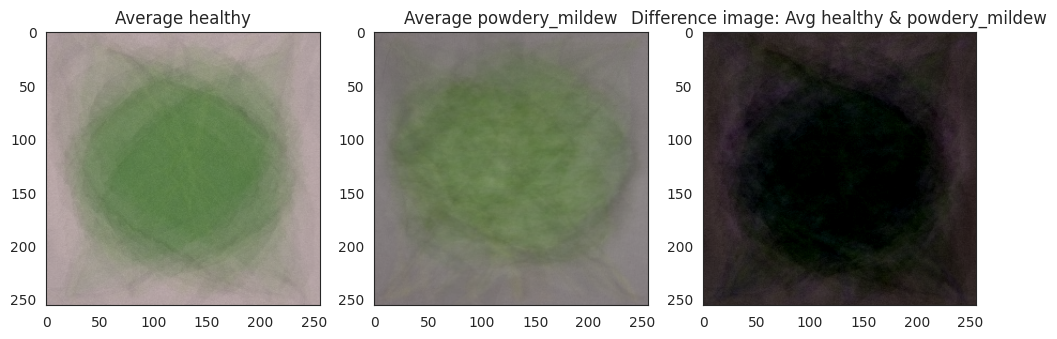

In [17]:
diff_as_array(X=X, y=y,
              label1='healthy',
              label2='powdery_mildew',
              figsize=(12,10),
              save_image=True)

## Montage

In [18]:
import itertools
import random
sns.set_style("white")

# check if label exists in the folder.
    #1.check if your montage space size is greather than your subset size
    #2.create your axes based on the number of rows and columns
    #3.create the figure 
    #4.display your images
        #load and plot images


def img_mont(dir_path, display_label, nrows, ncols, fig_size=(15,10)):
    #1
    labels = os.listdir(dir_path)
    if display_label in labels:
        img_list = os.listdir(dir_path+'/'+display_label)
        if nrows * ncols < len(img_list):
            img_idx=random.sample(img_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(img_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        rows_list= range(0,nrows)
        cols_list= range(0,ncols)
        plot_idx=list(itertools.product(rows_list,cols_list))
        #2
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=fig_size)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + display_label + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
    else: 
        print('The label you selected does not exist.')
        print(f"The label options you have are: {labels}")

healthy


powdery_mildew




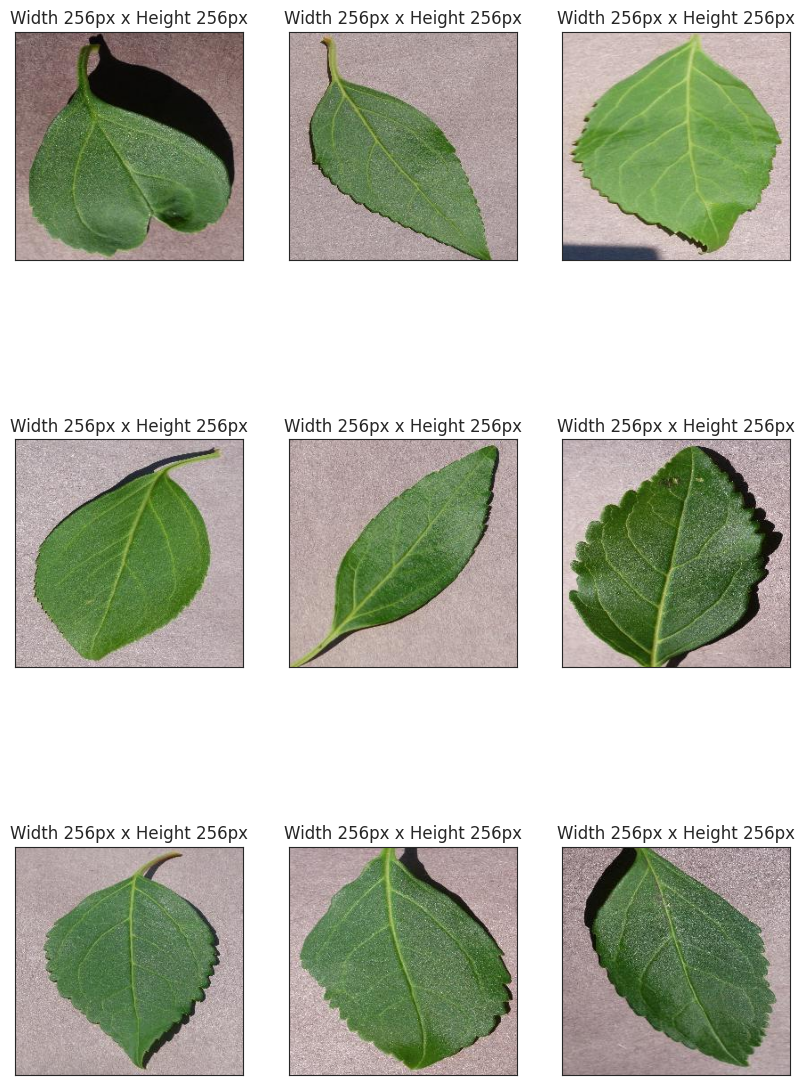

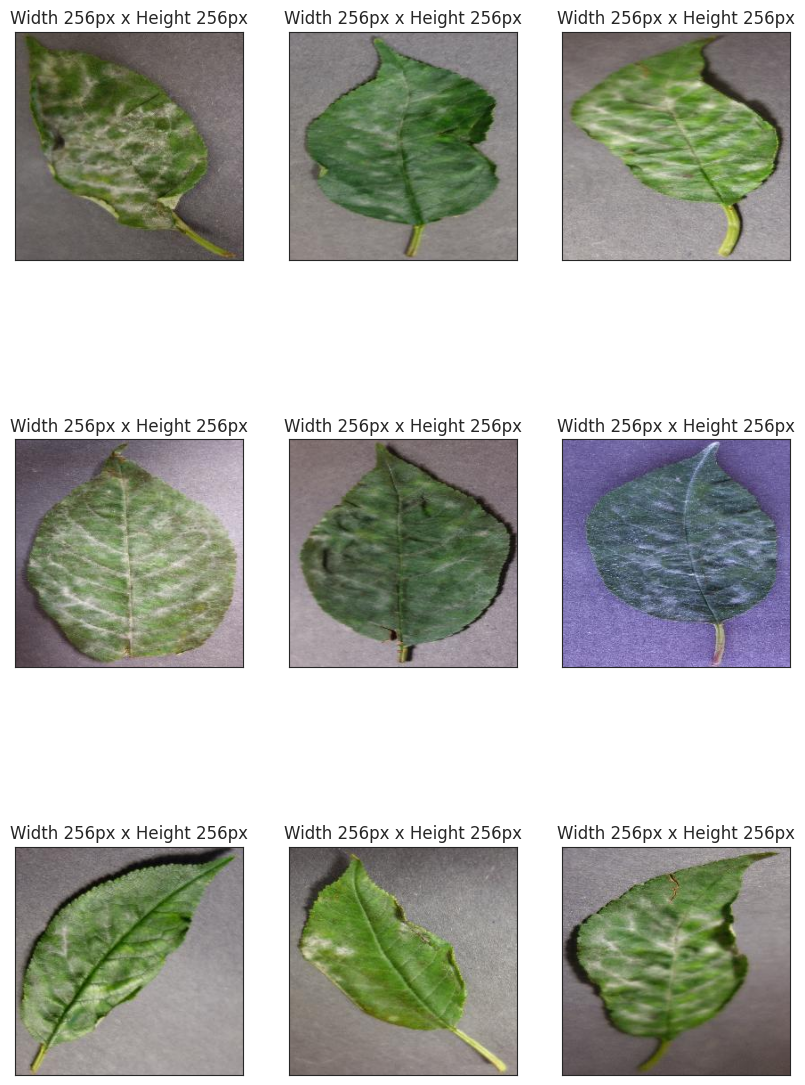

In [20]:
for label in labels:
  print(label)
  img_mont(dir_path= train_path,
                display_label= label,
                nrows=3, ncols=3,
                fig_size=(10,15)
                )
  print("\n")

## **Conclusions and Next Steps**

**Conclusions**
* Image data from the test set was resized.
* The differences between images from two labels were plotted.
* An image montage was created.
  
**Next Steps**
* Create the pipeline
* Create a model
* Check model with validation set
* Test the model on test set